Notebook to test, learn and love ;-)

In [12]:
import sys
import os
import time
import datetime
import random
import shutil
import tensorflow as tf
import tensorflow.keras.optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

import numpy as np
import matplotlib as mpimg
import matplotlib.pyplot as plt

SETUP DIRECTORY STRUCTURE FOR TRAINING AND TESTING

In [2]:
#no unzipping needed as directories already exist
#directory is: ~/Images/
def create_and_clear_dir_structure():
    try:
        if(os.path.isdir('Images/dandelion_v_other')):
            print('Directory dandelion_v_other found. Clearing out for next build.')
            shutil.rmtree('Images/dandelion_v_other/')
        
        os.mkdir('Images/dandelion_v_other/')
        os.mkdir('Images/dandelion_v_other/training')
        os.mkdir('Images/dandelion_v_other/testing')
        os.mkdir('Images/dandelion_v_other/training/dandelion')
        os.mkdir('Images/dandelion_v_other/testing/dandelion')
        os.mkdir('Images/dandelion_v_other/training/other')
        os.mkdir('Images/dandelion_v_other/testing/other')
    except OSError as e:
        print(f"OS DIR ERR: {e}")
        pass

create_and_clear_dir_structure()


Directory dandelion_v_other found. Clearing out for next build.


FUNCTION TO PROPERLY SPLIT UP OUR TRAIN/TEST IMAGES ACCORDING TO OUR SPLIT-SIZE RATIO. USUALLY .9/.1

In [3]:
###----------SPLIT THE DATA INTO TRAIN/TEST SETS-----------###
def split_data(SOURCE,TRAINING,TESTING,SPLIT_SIZE):
    img_list = os.listdir(SOURCE)
    random.shuffle(img_list)
    length_of_list = len(img_list)
    length_of_training_list = int(length_of_list*SPLIT_SIZE)
    length_of_test_list = length_of_list - length_of_training_list
    train_list = img_list[:length_of_training_list]
    test_list = img_list[length_of_training_list:]

    print(f"size:{length_of_list}")
    print(f"TRAIN size:{length_of_training_list}")
    print(f"TEST size:{length_of_test_list}")

    for file in train_list:
        full_img_path = SOURCE+file
        #print(f"TRAIN: {full_img_path}")
        if(os.path.getsize(full_img_path) < 0): #double check no 0 length image files
            img_list.remove(file)
            print(f"Found 0 length image file: {file}")
            print(f"File has been removed.")
        else:
            copyfile(full_img_path,TRAINING+file)

    for file in test_list:
        full_img_path = SOURCE + file
        #print(f"TEST: {full_img_path}")
        if (os.path.getsize(full_img_path) < 0):  # double check no 0 length image files
            img_list.remove(file)
            print(f"Found 0 length image file: {file}")
            print(f"File has been removed.")
        else:
            copyfile(full_img_path, TESTING + file)

DANDELION_SOURCE_DIR   = "Images/dandelion/"
OTHER_SOURCE_DIR       = "Images/other/"
TRAINING_DANDELION_DIR = "Images/dandelion_v_other/training/dandelion/"
TESTING_DANDELION_DIR  = "Images/dandelion_v_other/testing/dandelion/"
TRAINING_OTHER_DIR     = "Images/dandelion_v_other/training/other/"
TESTING_OTHER_DIR      = "Images/dandelion_v_other/testing/other/"


split_ratio = 0.9
split_data(DANDELION_SOURCE_DIR,TRAINING_DANDELION_DIR,TESTING_DANDELION_DIR,split_ratio)
split_data(OTHER_SOURCE_DIR,TRAINING_OTHER_DIR,TESTING_OTHER_DIR,split_ratio)

len_of_training_len = len(os.listdir('Images/dandelion_v_other/training/dandelion/')) + len(os.listdir('Images/dandelion_v_other/training/other/'))

print(len(os.listdir('Images/dandelion_v_other/training/dandelion/')))
print(len(os.listdir('Images/dandelion_v_other/training/other/')))
print(len(os.listdir('Images/dandelion_v_other/testing/dandelion/')))
print(len(os.listdir('Images/dandelion_v_other/testing/other/')))


size:635
TRAIN size:571
TEST size:64
size:627
TRAIN size:564
TEST size:63
571
564
64
63


BUILD MODEL

In [4]:
def create_model():
    model = tf.keras.models.Sequential([
        #we'll use 150x150 size and 3 color model
        tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        #Flatten the results fo feed into DNN
        tf.keras.layers.Flatten(),
        #pass into 512 neuron hidden layer
        tf.keras.layers.Dense(512,activation='relu'),
        #Single output neuron...its a dandelion or not
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])

    model.compile(optimizer=RMSprop(lr=1e-05),loss='binary_crossentropy',metrics=['accuracy'])
    return model


TRAIN MODEL: Including ImageGenerator so we can just hand off images via flow_from_directory method

In [5]:
def run_training(model):
    TRAINING_DIR = 'Images/dandelion_v_other/training'
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    #train w/batch size of 10
    train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                        batch_size=24,
                                                        class_mode='binary',
                                                        target_size=(150,150))

    VALIDATION_DIR = 'Images/dandelion_v_other/testing'
    validation_datagen = ImageDataGenerator( rescale= 1./255)


    validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                  batch_size=24,
                                                                  class_mode='binary',
                                                                  target_size=(150,150))

    checkpoint_path = "training_1/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)
    
    #4 epochs for testing, however 20-30 seems more appropriate for training
    history = model.fit(train_generator,
                                  epochs=4,verbose=1,
                                  validation_data = validation_generator,
                                  callbacks=[cp_callback])

    return history

REVIEW VIA PLOTS

In [6]:
def plot_history(history):
    #-----------------------------------------------
    # Get list of results on training and test data
    # for each epoch
    #-----------------------------------------------
    acc     = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss    = history.history['loss']
    val_loss= history.history['val_loss']

    epochs = range(len(acc))

    #-----------------------------------------------
    #Plot train/validation accuracy
    #-----------------------------------------------
    plt.plot(epochs,acc,'r',label="Training Accuracy")
    plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
    plt.title('Training and validation accuracy')
    plt.legend()
    #-----------------------------------------------
    #Plot train/validation loss
    #-----------------------------------------------
    plt.plot(epochs,loss,'r',label="Training Loss")
    plt.plot(epochs,val_loss,'b',label="Validation Loss")
    plt.title('Training and validation loss')
    plt.legend()



Build and see what we get!


In [7]:
model = create_model()
time_start = round(time.time())
history = run_training(model)
time_end = round(time.time())

Found 1135 images belonging to 2 classes.
Found 127 images belonging to 2 classes.
Epoch 1/4
48/48 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5198
Epoch 00001: saving model to training_1/cp.ckpt
48/48 [==============================] - 199s 4s/step - loss: 0.6923 - accuracy: 0.5198 - val_loss: 0.6919 - val_accuracy: 0.5039
Epoch 2/4
48/48 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5339
Epoch 00002: saving model to training_1/cp.ckpt
48/48 [==============================] - 196s 4s/step - loss: 0.6894 - accuracy: 0.5339 - val_loss: 0.6881 - val_accuracy: 0.5512
Epoch 3/4
48/48 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.5533
Epoch 00003: saving model to training_1/cp.ckpt
48/48 [==============================] - 195s 4s/step - loss: 0.6895 - accuracy: 0.5533 - val_loss: 0.6842 - val_accuracy: 0.5984
Epoch 4/4
48/48 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.5595
Epoch 00004

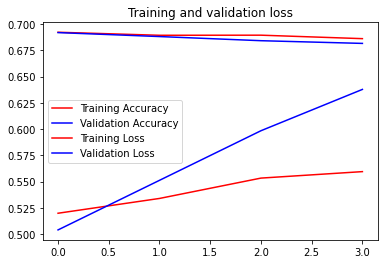

In [8]:
plot_history(history)

In [13]:
last_completed_training = datetime.datetime.now()
last_completed_accuracy = history.history['accuracy']
last_completed_loss =  history.history['loss']

acc      = np.array(history.history['accuracy']).mean()
val_acc  = np.array(history.history['val_accuracy']).mean()
loss     = np.array(history.history['loss']).mean()
val_loss = np.array(history.history['val_loss']).mean()

last_date_time_of_completed_training = datetime.datetime.now().strftime("%c")
length_of_time_for_training = time_end - time_start

fp = open(f"{os.getcwd()}/metrics/metrics.csv","w")
fp.write("Last_Accuracy;Last_Loss;Validation_Loss;Length_of_Training;Last_Training_Finish;Total_Images\n")
data_string = f"{acc};{loss};{val_loss};{length_of_time_for_training};{last_date_time_of_completed_training};{len_of_training_len}\n"
fp.write(data_string)
fp.close()

def model_quality_save(acc,model,threshold=0.50):
    if(acc > threshold):
        print(f"Model achieved {acc}% accuracy!\nSaving dandy_model.h5 for use.")
        model.save('saved_models/dandy_model_latest.h5')
    else:
        #send message that model was not good with acc/loss/val_acc/val_loss
        print(f"Model only made it to {acc}. Not saving. ")
        pass

print(acc)
model_quality_save(acc,model)


0.5416299551725388
Model achieved 0.5416299551725388% accuracy!
Saving dandy_model.h5 for use.
